####  Проектная работа по курсу Теории вероятностей и математической статистики
Тема проектной работы "Влияние опыта режиссёра на результат картины".

Исходные данные: 
1. https://datasets.imdbws.com (база по фильмам):  
 * title.basics.tsv - список фильмов с годом выходам
 * title.crew.tsv - список фильмов с перечнем режиссеров
 * title.ratings.tsv - рейтинг фильмов

Задание:   
1. Проанализировать информацию о фильмах и проверить гипотезу "Первый блин комом" - первые фильмы режисеров не были удачными и имели рейтинг ниже среднего 
2. Предсказать рейтинг фильма, основываясь на опыте режиссёра  

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('fast')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

#### Подготовка данных:

In [2]:
usecols = ['tconst', 'startYear', 'genres', 'titleType']
df_basics = pd.read_csv('title.basics.tsv', usecols=usecols, sep="\t")
df_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5890061 entries, 0 to 5890060
Data columns (total 4 columns):
tconst       object
titleType    object
startYear    object
genres       object
dtypes: object(4)
memory usage: 179.8+ MB


Отсеиваем фильмы без даты и оставляем только фильмы

In [3]:
df_basics = df_basics[df_basics['startYear'] != '\\N']
df_basics = df_basics[df_basics['titleType'] == 'movie']

In [4]:
usecols = ['tconst', 'directors']
df_crew = pd.read_csv('title.crew.tsv', usecols=usecols, sep="\t")
df_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892546 entries, 0 to 5892545
Data columns (total 2 columns):
tconst       object
directors    object
dtypes: object(2)
memory usage: 89.9+ MB


In [5]:
#Отсеиваем фильмы без режиссеров
df_crew = df_crew[df_crew['directors'] != '\\N']

#Оценим количество режиссеров у каждого фильма
def director_count(x):
    spam = x['directors'].split(',')        
    return len(spam)

df_crew['director_count'] = df_crew.apply(lambda x: director_count(x), axis =  1)

#Оценим с помощью Z-оценки выбросы по количеству режиссеров на 1 фильм
dx = df_crew[(np.abs(stats.zscore(df_crew['director_count'])) > 3)]
print(dx.shape[0]/df_crew.shape[0])
dx.describe()

0.006008182049433021


,director_count
count,20596.000000
mean,10.105457
std,12.081501
min,6.000000
25%,6.000000
50%,7.000000
75%,10.000000
max,431.000000


Уберем выбросы из выборки с очень большим количеством режиссеров, чтобы облегчит работу алгоритма. А в виду незначительности (менее 1% от общего количества) данное действие не должно существенно повлиять на модель.

In [6]:
#Отсеиваем фильмы с большим количеством режисеров, 
df_crew = df_crew[df_crew['director_count'] <= 5]
df_crew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3407396 entries, 0 to 5892545
Data columns (total 3 columns):
tconst            object
directors         object
director_count    int64
dtypes: int64(1), object(2)
memory usage: 104.0+ MB


In [7]:
#объединение DataFrame по ключу фильма
main = pd.merge(df_crew, df_basics, on='tconst')
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433828 entries, 0 to 433827
Data columns (total 6 columns):
tconst            433828 non-null object
directors         433828 non-null object
director_count    433828 non-null int64
titleType         433828 non-null object
startYear         433828 non-null object
genres            433828 non-null object
dtypes: int64(1), object(5)
memory usage: 23.2+ MB


In [8]:
#чтение информации о рейтингах
usecols = ['tconst', 'averageRating', 'numVotes']
df_ratings = pd.read_csv('title.ratings.tsv', usecols=usecols, sep="\t")
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937829 entries, 0 to 937828
Data columns (total 3 columns):
tconst           937829 non-null object
averageRating    937829 non-null float64
numVotes         937829 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.5+ MB


In [9]:
#объединение DataFrame по ключу фильма
main = pd.merge(main, df_ratings, on='tconst', how='left')
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433828 entries, 0 to 433827
Data columns (total 8 columns):
tconst            433828 non-null object
directors         433828 non-null object
director_count    433828 non-null int64
titleType         433828 non-null object
startYear         433828 non-null object
genres            433828 non-null object
averageRating     231024 non-null float64
numVotes          231024 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 29.8+ MB


In [10]:
# Выделим режиссеров каждого фильма, считая оценку заслугой каждого
def rule(x, index):
    spam = x['directors'].split(',')
    if len(spam) > index-1:
        return spam[index-1]
    else:
        return np.nan

for i in range(1,6): 
    main["director_{}".format(i)]  = main.apply(lambda x: rule(x, i), axis =  1)
    
result_column = ['tconst', 'director', 'titleType', 'startYear', 'genres', 'averageRating', 'numVotes', 'director_count']
result = pd.DataFrame(columns = result_column);
for i in range(1,6):
    spam = main[main['director_count'] >= i].copy()
    spam = spam.rename(columns={"director_{}".format(i): "director"})
    spam = spam[result_column]
    result = result.append(spam, ignore_index=True, sort=True)

In [11]:
result.describe(include='all')

,averageRating,director,director_count,genres,numVotes,startYear,tconst,titleType
count,253673.000000,474870,474870.0,474870,2.536730e+05,474870,474870,474870
unique,NaN,176712,5.0,1350,NaN,131,433828,1
top,NaN,nm0644554,1.0,Drama,NaN,2017,tt2652476,movie
freq,NaN,403,398867.0,81120,NaN,18935,5,474870
mean,6.228282,NaN,NaN,NaN,3.243046e+03,NaN,NaN,NaN
std,1.336199,NaN,NaN,NaN,3.048639e+04,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,5.000000e+00,NaN,NaN,NaN
25%,5.400000,NaN,NaN,NaN,1.400000e+01,NaN,NaN,NaN
50%,6.400000,NaN,NaN,NaN,4.600000e+01,NaN,NaN,NaN
75%,7.100000,NaN,NaN,NaN,2.460000e+02,NaN,NaN,NaN


In [12]:
# Сортировка по режиссеру и гол=ду выпуска
sort_result = result.sort_values(by=['director','startYear'], 
        ascending=True).head(10000) # для тестирования используем первые 10000 строк

In [13]:
from tqdm import tqdm_notebook
# добавление порядкового номера для фильма одного режиссера из отсортированного списка по годам
def add_serial(df):
    df['historyDirectorRating'] = 0
    df['SerialNumber'] = np.nan
    director = ''
    num_film = 0
    count_rating = 0
    sumAverageRating = 0 
    with tqdm_notebook(total=df.shape[0], desc='Add serials', leave=True) as bar1:
        for k, row in df.iterrows():
            
            if director == row['director']:  
                df.loc[k,'historyDirectorRating'] = sumAverageRating/count_rating
                df.loc[k,'SerialNumber'] = num_film
                num_film += 1                
                if row['averageRating'] != np.nan:
                    sumAverageRating += row['averageRating']
                    count_rating+=1
            else:
                director = row['director']
                df.loc[k,'historyDirectorRating'] = 0
                df.loc[k,'SerialNumber'] = 0             
                num_film = 1
                count_rating = 1
                if row['averageRating'] != pd.np.nan:
                    sumAverageRating = row['averageRating']                   
                
            bar1.update() 
    return df
sort_result = add_serial(sort_result)

In [14]:
#фиксируем итоговый DataSet
#sort_result.to_csv('sort_result.csv' index=False)

#### Анализ данных:

In [15]:
#восстанавливам итоговый DataSet
df = pd.read_csv('sort_result.csv')
#убираем фильмы без рейтинга
df = df[df['averageRating'].notnull()]
#находим все первые фильмы
firstfilm = df.loc[df['SerialNumber'] == 0,['tconst','director','averageRating']]

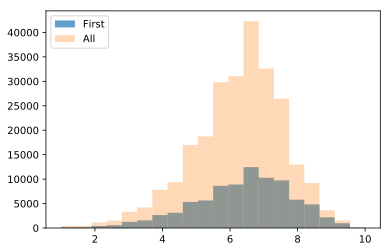

In [16]:
#Строим гистограмму, чтобы оценить распределение рейтинга
plt.hist(firstfilm['averageRating'], 20, alpha=0.7, label='First')
plt.hist(df['averageRating'], 20, alpha=0.3, label='All')
plt.legend(loc='upper left')
plt.show()

Распределение рейтинга всех фильмов является нормальной, т.к. каждая оценка является случайной, количество голосов большое, то среднее значение оценки фильмов распределено по нормальному закону распределения.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253673 entries, 0 to 474864
Data columns (total 12 columns):
averageRating            253673 non-null float64
director                 253673 non-null object
director_count           253673 non-null int64
genres                   253673 non-null object
numVotes                 253673 non-null float64
startYear                253673 non-null int64
tconst                   253673 non-null object
titleType                253673 non-null object
firstYear                253673 non-null int64
countMovie               253673 non-null int64
historyDirectorRating    171063 non-null float64
SerialNumber             253673 non-null float64
dtypes: float64(4), int64(4), object(4)
memory usage: 25.2+ MB


In [18]:
#Доля первых работ режиссеров в датасете:
firstfilm.shape[0]/df.shape[0]

0.3336894348235721

#### Задание 1. Проанализировать информацию о фильмах и проверить гипотезу "Первый блин комом" - первые фильмы режиссеров не были удачными

1. Гипотеза $H_0$: средний рейтинг первых фильмов меньше среднего рейтинга всех фильмом.    
2. $H_1$:  средний рейтинг перых фильмов не хуже среднего рейтийнга всех фильмов.    

In [19]:
firstfilm_mean = firstfilm['averageRating'].mean()
all_mean = df['averageRating'].mean()
nextfilm_mean = df.loc[df['SerialNumber'] != 0]['averageRating'].mean()
print(f'Среднее рейтинг первых фильмов: {firstfilm_mean:>10.7}')
print(f'Среднее рейтинг всех фильмов: {all_mean:>12.7}')
print(f'Среднее рейтинг непервых фильмов: {nextfilm_mean:>8.7}')

Среднее рейтинг первых фильмов:   6.356644
Среднее рейтинг всех фильмов:     6.228282
Среднее рейтинг непервых фильмов: 6.163999


Информация из гистограммы распределения рейтинга и средних значений выборки противоречат гипотезе, но нулевую гипотезу нет возможности отвергнуть с вероятностью P = 1 - α, если
$$
\left( 
\frac{\overline{X} - M(X)} {S / \sqrt{n}} \leq  t_{1 - \alpha, \: n - 1}  
 \right).
$$

In [20]:
t = stats.t.ppf(1-0.05, firstfilm['averageRating'].shape[0]-1)
print (f't={t}')
std = df['averageRating'].std()
print (f'Cтандартное отклонение генеральной совокупности={std}')
sqrt_n = np.sqrt( firstfilm['averageRating'].shape[0])
print (f'Корень из n={sqrt_n}')

t=1.6448716286045213
Cтандартное отклонение генеральной совокупности=1.3361988299603935
Корень из n=290.94329344392867


Итак, получаем фактическое значение статистического критерия

In [21]:
t = (firstfilm_mean - all_mean) / (std / sqrt_n )
t

27.949373858176155

Т.к. t = 27.95 > 1.64, т.е. фактическое значение статистического критерия больше критического значения, то фактическое значение не попадает в область принятия гипотезы. Следовательно, нет возможности принять основную гипотезу о том, что средний рейтинг первых фильмов меньше среднего рейтинга всех фильмом.

#### 2. Предсказать рейтинг фильма основываясь на опыте режиссёра

Парная модель регрессии, понимая под опытом количество ранее созданным режиссером фильмов, что соответствует полю SerialNumber:

In [22]:
x = df['SerialNumber'].values
y = df['averageRating'].values

Найдем коэффиценты парной линейной регрессии
$$y = b_0 + b_1 x, где$$
$y$ - прогноз значения средней оценки
$x$ - порядковый номер фильма (количество фильмов) режиссера
Для парной регрессии коэффициенты вычисляются по формулам:
$$b_1 = \frac{\overline{yx} - \overline{y} \cdot {\overline{x}}}{\overline{x^2} - (\overline{x})^2}, \: b_0 = \overline{y} - b_1 \cdot {\overline{x}}.$$  
Где $x$, $y$ — данные из выборки, $\overline{x}$ обозначает выборочное среднее

In [23]:
def koeff(x, y):
    b1 = (np.mean(y * x) - np.mean(y) * np.mean(x)) / (np.mean(x ** 2) - np.mean(x) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return (b0, b1)

b0, b1 = koeff(x, y)
print(f'модель линейной регрессии имеет вид: y = {b0} {b1} * x')

модель линейной регрессии имеет вид: y = 6.261151056471449 -0.004047656055742476 * x


Итак, модель линейной регрессии имеет вид:

$$y = 6.261151056471449 -0.004047656055742476 \cdot x,$$

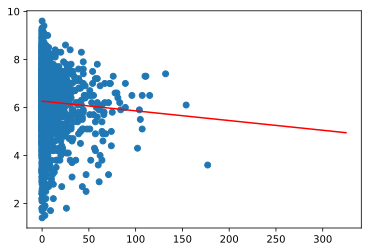

In [24]:
ox = x
oy = b0 + b1 * ox
rows = df.sample(2000)
plt.scatter(rows['SerialNumber'].values, rows['averageRating'].values)
plt.plot(ox, oy, color='red')

In [25]:
pred_y = b0 + b1 * x
R1 = pred_y.var() / y.var()
print(f'Итак, коэффициент детерминации:{R1}')

Итак, коэффициент детерминации:0.0026132482888972077


In [26]:
def mean_approximation_error(y_real, y_pred):
    return np.abs((y_real - y_pred) / y_real).mean()
A = mean_approximation_error(y, pred_y)
print(f'Cредняя ошибка аппроксимации:{A}')

Cредняя ошибка аппроксимации:0.20516464084693287


Т.к. $\overline{A}$ превышает $8-10 \%$, а коэффициент детерминации практически равен 0, то можно сказать, что теоретические значения далеки от тех, которые выдает модель линейной регрессии.

Проведем оценку с помощью F-критерия Фишера.

In [27]:
def check_FTest(k, n, R1, alpha=0.05):
    F_fact = (R1 / (1 - R1)) * (n - k - 1 / k)   
    F_crit = stats.f.ppf(1 - alpha, k, n - k - 1)
    print(f'T = {F_fact}, F_crit={F_crit}')
    return F_fact>F_crit    

In [28]:
k = 1
n = y.shape[0]
check_FTest(k, n, R1)

T = 664.6421817369967, F_crit=3.841495479282791


True

Т.к. значение статистики  $F_{fact} > F_{crit}$ (664.64 > 3.84), поэтому уравнение регрессии статистически значимо

Оценим значимости коэффицента наклона b1 для новой модели:

Стандартной ошибки коэффициента наклона вычисляем по формуле:

$$S_{slope} = \sqrt{\dfrac{\frac{1}{n - 2} \displaystyle\sum_{i=1}^{n}(y_i - z_i)^2}{\displaystyle\sum_{i=1}^n (x_i - \overline{x})^2}},$$

где:
* $x$, $x_i$ - соответственно, все значения и конкретное значение фактора
* $y_i$ - конкретное значение оцениваемой (целевой) переменной
* $z_i$ - "предсказанное" значение, полученное с помощью модели регрессии
* $n$ - число элементов в выборке

In [29]:
def standard_error_slope(x, y, z):
    n = x.shape[0]
    
    upper = ((y - z) ** 2).sum() / (n - 2)
    lower = ((x - x.mean()) ** 2).sum()
    
    return np.sqrt(upper / lower)

s_slope = standard_error_slope(x, y, pred_y)
T = b1 / s_slope
s_slope, T

(0.0001570036147953111, -25.78065518440126)

Зададим уровень значимости  $\alpha$=0.05 и найдем значение  $T_{crit}$.

In [30]:
t = stats.t.ppf(1 - 0.05/2,  x.shape[0]-2)
t

1.9599733363475407

Интервал критической области:
    $$\Omega_\alpha = \left( -\infty, - t_{1 - \alpha/2, \: n - 2} \right) \cup \left( t_{1 - \alpha/2, \: n - 2}, \infty \right) = \left( -\infty, - 1.96 \right) \cup \left( 1.96, \infty \right).$$

Значение $T_{fact}$ попало в критическую область, значит, гипотеза о равенстве нулю параметра  b1 отвергается. Доверительный интервал для параметра  b1.

In [31]:
(b1 - t * s_slope, b1 + t * s_slope)

(-0.004355378954451466, -0.003739933157033486)

Оценим значимости b0:

Стандартная ошибка коэффициента сдвига вычисляется по формуле:

$$S_{intercept} = S_{slope} \cdot \sqrt{\dfrac{1}{n} \displaystyle\sum_{i=1}^n x_i^2}.$$

In [32]:
def standard_error_intercept(x, y, z):
    return standard_error_slope(x, y, z) * np.sqrt((x ** 2).mean())
s_intercept = standard_error_intercept(x, y, pred_y)
s_intercept

0.0029403042339282448

In [33]:
T = b0 / s_intercept
T

2129.422861833095

Значение попало в критическую область, значит, значение параметра $b_0$ является значимым.

Доверительный интервал для параметра $b_0$:

In [34]:
(b0 - t * s_intercept, b0 + t * s_intercept)

(6.2553881385722, 6.266913974370698)

Корреляция между рейтингом фильма и опытом режиссера

In [35]:
df_sorted = df[['averageRating', 'SerialNumber']]
corr = df_sorted.corr()
corr

,averageRating,SerialNumber
averageRating,1.00000,-0.05112
SerialNumber,-0.05112,1.00000


Проверим расчеты с использоваием готовой библиотеки sklearn.linear_model

In [36]:
from sklearn.linear_model import LinearRegression
X=df['SerialNumber'].values.reshape(len(df['SerialNumber'].values),1)
Y=df['averageRating'].values.reshape(len(df['averageRating'].values),1)
regr = LinearRegression(normalize=True, copy_X=True)  
regr.fit(X, Y)
regr.intercept_, regr.coef_, regr.score(X, Y)

(array([6.26]), array([[-0.00404766]]), 0.0026132482888968633)

##### Вывод:
Влияние на рейтинг фильма количество, созданных ранее режиссером фильмом, есть, но оно очень слабое. 
При этом оценка последующих фильмов режиссера снижается, что также косвенно подтверждает ошибочность гипотезы "Первый блин комом".
Но в целом модель получилось слабая и предсказывает с большой ошибкой.